In [0]:
!pip install tensorflow_hub

In [0]:
import matplotlib
matplotlib.use("Agg")

In [0]:
'''
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pylab as plt
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from keras.optimizers import SGD
'''

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd

In [0]:
pd.set_option("display.precision", 8)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_root='/content/drive/My Drive/VideoTestCases/train'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,
                  subset="validation",
                  shuffle=True,
                  target_size=IMAGE_SHAPE
                )

train_datagen = ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
                  TRAINING_DATA_DIR,
                  subset="training",
                  shuffle=True,
                  target_size=IMAGE_SHAPE)

/content/drive/My Drive/VideoTestCases/train
Found 902 images belonging to 3 classes.
Found 3617 images belonging to 3 classes.


In [0]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
['Blur' 'Macroblocking' 'Normal']


In [0]:

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# apply CONV => BN => ACT => POOL to reduce spatial size
		x = Conv2D(filters[0], (5, 5), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = ZeroPadding2D((1, 1))(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [0]:
#!pip install tensorflow==1.14.0

print("[INFO] compiling model...")

INIT_LR = 1e-1
BS = 8
EPOCHS = 10

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / EPOCHS)
model = ResNet.build(224, 224, 3, 3, (3, 3, 4),
	(32, 64, 128, 256), reg=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [0]:
from imutils import paths

trainPaths = list(paths.list_images('/content/drive/My Drive/VideoTestCases/train'))
totalTrain = len(trainPaths)
print(totalTrain)
valPaths = list(paths.list_images('/content/drive/My Drive/VideoTestCases/train'))
totalVal = len(valPaths)
print(totalVal)
aug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")
print("[INFO] training network for {} epochs...".format(EPOCHS))

trainGen = aug.flow_from_directory(
	'/content/drive/My Drive/VideoTestCases/train',
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	class_weight=classWeight,
	epochs=NUM_EPOCHS)
'''

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit_generator(
                      train_generator, epochs=EPOCHS, verbose=1,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=valid_generator,
                      validation_steps=val_steps_per_epoch
      ).history
'''
model.save("/content/drive/My Drive/3kImages/models/ImageQuality_ResnetV1.h5")
model.save_weights("/content/drive/My Drive/3kImages/models/ImageQuality_ResnetV1_Weights.h5")


In [0]:
model = tf.keras.Sequential([
          hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          output_shape=[1280],
          trainable=False),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
          ])

model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit_generator(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

model.save("/content/drive/My Drive/3kImages/models/ImageQualityV4.h5")
model.save_weights("/content/drive/My Drive/3kImages/models/ImageQualityV4Weights.h5")

Epoch 1/10
375/375 [==============================] - 4258s 11s/step - loss: 0.1281 - acc: 0.8973 - val_loss: 0.0354 - val_acc: 0.9960
Epoch 2/10
375/375 [==============================] - 663s 2s/step - loss: 0.0419 - acc: 0.9901 - val_loss: 0.0300 - val_acc: 0.9957
Epoch 3/10
375/375 [==============================] - 675s 2s/step - loss: 0.0293 - acc: 0.9915 - val_loss: 0.0208 - val_acc: 0.9967
Epoch 4/10
375/375 [==============================] - 668s 2s/step - loss: 0.0265 - acc: 0.9933 - val_loss: 0.0234 - val_acc: 0.9957
Epoch 5/10
375/375 [==============================] - 671s 2s/step - loss: 0.0228 - acc: 0.9958 - val_loss: 0.0201 - val_acc: 0.9977
Epoch 6/10
375/375 [==============================] - 675s 2s/step - loss: 0.0219 - acc: 0.9942 - val_loss: 0.0173 - val_acc: 0.9977
Epoch 7/10
375/375 [==============================] - 676s 2s/step - loss: 0.0202 - acc: 0.9952 - val_loss: 0.0220 - val_acc: 0.9963
Epoch 8/10
375/375 [==============================] - 681s 2s/step 

In [0]:
model.save("/content/drive/My Drive/3kImages/models/ImageQualityV2.h5")
model.save_weights("/content/drive/My Drive/3kImages/models/ImageQualityV2Weights.h5")

In [0]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Validation batch shape: (32, 224, 224, 3)
Prediction results for the first elements


,Blurry,Macroblocking,Normal
0,0.00000442,9.99990702e-01,4.93232756e-06
1,1.00000000,3.83912173e-11,6.59996363e-11
2,0.00000007,9.99997139e-01,2.80120889e-06
3,0.00000005,9.99999166e-01,8.69279120e-07
4,0.00000150,9.99989867e-01,8.63337937e-06


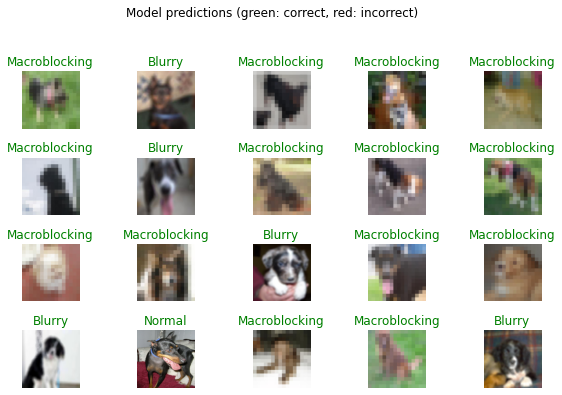

In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
from keras import models
#theModel = models.load_model('/content/drive/My Drive/3kImages/models/ImageQuality1.h5')
new_model = tf.keras.models.load_model('/content/drive/My Drive/3kImages/models/ImageQualityV4.h5',custom_objects={'KerasLayer':hub.KerasLayer})
new_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

# image folder
folder_path = '/content/drive/My Drive/3kImages/miniTest/MacroBlocking'
# path to model
model_path = '/path/to/saved/model.h5'
# dimensions of images
img_width, img_height = 224, 224


# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    images.append(img)
    #print(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = new_model.predict_classes(images, batch_size=10)
print(classes)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
[1 1 1 1 1 0 0 1 1 0 2]


In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

# image folder
folder_path = '/content/drive/My Drive/3kImages/test/MacroBlocking'
# path to model
model_path = '/path/to/saved/model.h5'
# dimensions of images
img_width, img_height = 224, 224


# load all images into a list
images = []
img = "/content/drive/My Drive/3kImages/test/MacroBlocking/5072.jpg"
img = image.load_img(img, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = new_model.predict_classes(images, batch_size=10)
print(classes)

[1]


In [0]:
test_image = image.load_img('/content/drive/My Drive/3kImages/test/MacroBlocking/5072.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image/255

print(test_image.shape)

result = new_model.predict(test_image)
predict_proba = new_model.predict_proba(test_image)
prediction_result = np.argmax(result[0])
print(prediction_result)


(1, 224, 224, 3)
1


Found 24 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]


<Figure size 864x864 with 0 Axes>

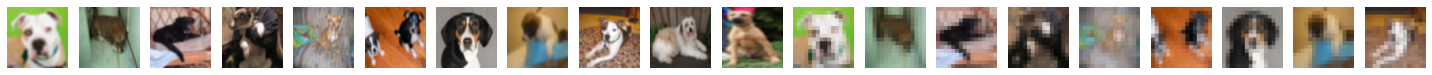

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 2 2]


In [0]:
from keras.preprocessing.image import ImageDataGenerator

data_root='/content/drive/My Drive/3kImages/miniTest'

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=TRAINING_DATA_DIR, target_size = (224, 224),
                                            batch_size = 32, shuffle=False)

sample_training_images, _ = next(test_set)
print(test_set.labels)
plt.figure(figsize=(12, 12))

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 20, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:20])

total_validate = 44
batch_size = 32

predict = new_model.predict(test_set, steps=np.ceil(total_validate/32))
predict=np.round(predict,decimals=5)
result = map(lambda v : np.argmax(v), predict)
prediction_result = np.array(list(result))
print(prediction_result)
#print(predict)

#test_labels = np.array(np.zeros(44))
#print(test_labels.shape)
#my_data = (test_set, test_labels)
#test_loss, test_acc = new_model.evaluate(my_data)
#print(test_acc)


In [0]:
import sklearn.metrics as metrics
classification_report = metrics.classification_report(test_set.labels, prediction_result, target_names = test_set.class_indices.keys())
print("Classification report: \n", classification_report)
confusion_matrix = metrics.confusion_matrix(test_set.labels, prediction_result)
print("Confusion matrix: \n",confusion_matrix)